### Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
path = "/content/drive/MyDrive/HW5/1_VAE/5_1_2_implementation/2d_gaussian/"
sys.path.append(path)
os.makedirs(path+'/checkpoint/',exist_ok = True)

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from helper.visualize import plot_scatter_2d, visualize_samples, plot_vae_training_plot
import torch.nn.functional as F

In [4]:
from encoder import Encoder
from decoder import Decoder 

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
num_workers = 8 if cuda else 0

### Load npy files

In [6]:
# load training and test files 
train_data   = np.load(path+'data/train_data.npy')
train_labels = np.load(path+'data/train_labels.npy')
test_data    = np.load(path+'data/test_data.npy')
test_labels  = np.load(path+'data/test_labels.npy')

### Visualize 

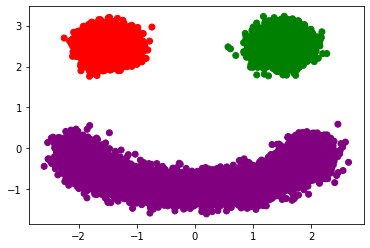

In [7]:
plot_scatter_2d(test_data, labels = test_labels)

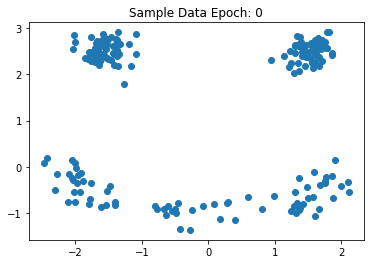

In [8]:
visualize_samples(train_data[:200,:],0)

### Dataloader

In [9]:
batch_size = 32

In [10]:
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle=True)
test_loader  = DataLoader(test_data,batch_size = batch_size, shuffle=False)

### Model

In [11]:
class VAE(nn.Module):
	def __init__(self,zdim):
		super(VAE,self).__init__()
		self.encoder = Encoder(zdim)
		self.decoder = Decoder(zdim)

	def sample(self,mu,logvar):
		std = torch.exp(0.5*logvar)
		eps = torch.randn_like(std)
		return eps.mul(std).add_(mu)



	def forward(self,x):
		mu,logvar = self.encoder(x)
		z 		  = self.sample(mu,logvar)
		return self.decoder(z), mu, logvar

### Loss function

In [12]:
def gaussian_nll_from_mse(x, x_recon):
    pi = math.pi
    MSE = torch.square(x-x_recon).mean(axis=-1)
    return torch.sum(0.5*(torch.log(2*pi*MSE)+1))


In [13]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    recon_loss  =gaussian_nll_from_mse(x,recon_x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss/batch_size, KLD/batch_size

### Train

In [14]:
def train(model, train_loader, optimizer):
    """
    Returns elbo, reconstruction loss and kl loss per epoch
    """
    elbo      = 0.0
    rec_loss  = 0.0
    kl_loss   = 0.0
    
    model.train()
    for x in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        recon_x,mu,logvar = model(x)
        loss_rec, loss_kl = loss_function(recon_x, x, mu, logvar)

        (loss_rec + loss_kl).backward()
  
        rec_loss += loss_rec.item()
        kl_loss  += loss_kl.item()
        elbo  = -(loss_rec + loss_kl).item() # negative likelihodd L_recon + KLD

        optimizer.step()
        

        del x
        torch.cuda.empty_cache()
        
    return elbo/len(train_loader), rec_loss/len(train_loader), kl_loss/len(train_loader)


In [15]:

def test(model, loader):
    """
    Returns elbo, reconstruction loss and kl loss per epoch
    """
    elbo      = 0.0
    rec_loss  = 0.0
    kl_loss   = 0.0

    model.eval()
    
    for x in loader:
        x = x.to(device)
        recon_x,mu,logvar = model(x)
        loss_rec, loss_kl = loss_function (recon_x, x, mu, logvar)
        
        rec_loss += loss_rec.item()
        kl_loss  += loss_kl.item()
        elbo      = -(loss_rec + loss_kl).item()
        del x
        torch.cuda.empty_cache()
    
    return elbo/len(loader), rec_loss/len(loader), kl_loss/len(loader)

    

In [16]:
def trainer(model, train_loader, test_loader, optimizer, epochs):
    """
    Return lists below
    """
    # Training 
    tr_elbos, tr_recons, tr_kls = [], [], []
    # Testing
    te_elbos, te_recons, te_kls = [], [], []
    
    # Iterate over epochs
    for n in range(epochs):
        # train
        elbo, rec_loss, kl_loss = train(model, train_loader, optimizer)
        tr_elbos.append(elbo)
        tr_recons.append(rec_loss)
        tr_kls.append(kl_loss)
        
        # Report at each epoch
        print(f" epoch : {n+1}, tr_recon_loss : {rec_loss}, tr_kl_loss : {kl_loss}")
        
        # test
        elbo, rec_loss, kl_loss = test(model, test_loader)
        te_elbos.append(elbo)
        te_recons.append(rec_loss)
        te_kls.append(kl_loss)        
        
        # Report at each epoch
        print(f" epoch : {n+1}, te_recon_loss : {rec_loss}, te_kl_loss : {kl_loss}")
        if (n+1)%5 == 0 :
          # Visualize learning
          model.eval()
          z = torch.randn(500, zdim).cuda()
          gene_sample = model.decoder(z).cpu().detach()
          visualize_samples(gene_sample,n)
          # Visualize latent space 
        
    # Plot graph 
    plot_vae_training_plot(tr_elbos, tr_recons, tr_kls,epochs, 'Performance train')
    plot_vae_training_plot(te_elbos, te_recons, te_kls, epochs, 'Performance test')

    PATH = path+'/checkpoint/encoder.pt'
    torch.save(model.encoder.state_dict(), PATH)

    PATH = path+'/checkpoint/decoder.pt'
    torch.save(model.decoder.state_dict(), PATH)

In [17]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)
    nn.init.constant_(m.bias, 0.0)

 epoch : 1, tr_recon_loss : 1.6692246686553955, tr_kl_loss : 16.646584756355285
 epoch : 1, te_recon_loss : 1.6353194980365235, te_kl_loss : 0.419153209899545
 epoch : 2, tr_recon_loss : 1.5876513661575318, tr_kl_loss : 1.7996576612472535
 epoch : 2, te_recon_loss : 1.5259507440621285, te_kl_loss : 0.23420468159496327
 epoch : 3, tr_recon_loss : 1.5046452419853211, tr_kl_loss : 1.2106669095420837
 epoch : 3, te_recon_loss : 1.4692340260347747, te_kl_loss : 0.21107029663327406
 epoch : 4, tr_recon_loss : 1.4484093149757384, tr_kl_loss : 0.8744549239730834
 epoch : 4, te_recon_loss : 1.4131250004558003, te_kl_loss : 0.1755577173903394
 epoch : 5, tr_recon_loss : 1.384313115348816, tr_kl_loss : 0.6821963430786133
 epoch : 5, te_recon_loss : 1.3289630068537523, te_kl_loss : 0.20600948286483356


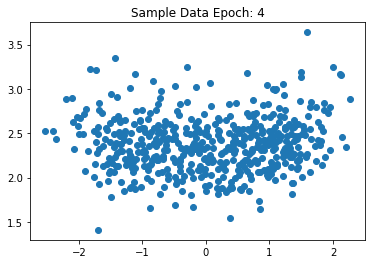

 epoch : 6, tr_recon_loss : 1.3397989383888245, tr_kl_loss : 0.5574440779972076
 epoch : 6, te_recon_loss : 1.304205910552798, te_kl_loss : 0.17495930074568827
 epoch : 7, tr_recon_loss : 1.2998557069778442, tr_kl_loss : 0.49070797609329225
 epoch : 7, te_recon_loss : 1.2897805128713398, te_kl_loss : 0.17510185395474628
 epoch : 8, tr_recon_loss : 1.2751528646564483, tr_kl_loss : 0.44565268374443057
 epoch : 8, te_recon_loss : 1.260556847847941, te_kl_loss : 0.18272653796121746
 epoch : 9, tr_recon_loss : 1.2532487166023254, tr_kl_loss : 0.4161515595340729
 epoch : 9, te_recon_loss : 1.216589921270795, te_kl_loss : 0.20675999084797203
 epoch : 10, tr_recon_loss : 1.2317201287078858, tr_kl_loss : 0.38276023322105407
 epoch : 10, te_recon_loss : 1.2097842661316132, te_kl_loss : 0.19421608332077714


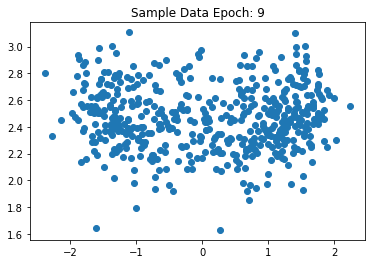

 epoch : 11, tr_recon_loss : 1.2130933352088928, tr_kl_loss : 0.37027006170272825
 epoch : 11, te_recon_loss : 1.1826554155715592, te_kl_loss : 0.19409009489609533
 epoch : 12, tr_recon_loss : 1.1921187811088563, tr_kl_loss : 0.35492944945812227
 epoch : 12, te_recon_loss : 1.1646218496134213, te_kl_loss : 0.21707256927209742
 epoch : 13, tr_recon_loss : 1.182975910396576, tr_kl_loss : 0.339635890994072
 epoch : 13, te_recon_loss : 1.1730236412237978, te_kl_loss : 0.1965177823382113
 epoch : 14, tr_recon_loss : 1.173150418806076, tr_kl_loss : 0.3203351865243912
 epoch : 14, te_recon_loss : 1.1540204841081443, te_kl_loss : 0.1977819680615002
 epoch : 15, tr_recon_loss : 1.1605719163513184, tr_kl_loss : 0.3160643089962006
 epoch : 15, te_recon_loss : 1.1474136721600048, te_kl_loss : 0.1921678325280433


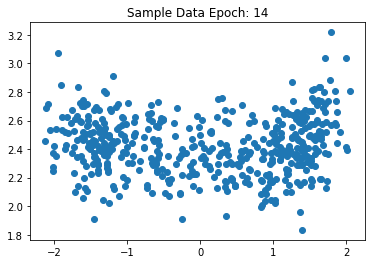

 epoch : 16, tr_recon_loss : 1.1395055383396149, tr_kl_loss : 0.309405568523407
 epoch : 16, te_recon_loss : 1.1394573378440973, te_kl_loss : 0.18744128664521992
 epoch : 17, tr_recon_loss : 1.1410216535568238, tr_kl_loss : 0.29806892955303194
 epoch : 17, te_recon_loss : 1.108105850760894, te_kl_loss : 0.20749188782147054
 epoch : 18, tr_recon_loss : 1.1247088214969636, tr_kl_loss : 0.297138041138649
 epoch : 18, te_recon_loss : 1.1470153777267011, te_kl_loss : 0.17369421577209707
 epoch : 19, tr_recon_loss : 1.1033243712711334, tr_kl_loss : 0.3003672030878067
 epoch : 19, te_recon_loss : 1.0873689936173847, te_kl_loss : 0.2246874684224958
 epoch : 20, tr_recon_loss : 1.0991779324817657, tr_kl_loss : 0.28824476576805114
 epoch : 20, te_recon_loss : 1.0966739613762901, te_kl_loss : 0.20366081886965295


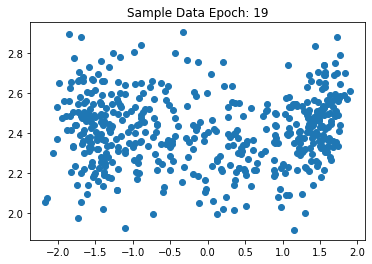

 epoch : 21, tr_recon_loss : 1.125221342496872, tr_kl_loss : 0.28347821254730227
 epoch : 21, te_recon_loss : 1.0945863263000308, te_kl_loss : 0.19910668042462196
 epoch : 22, tr_recon_loss : 1.0852251188659667, tr_kl_loss : 0.28112024528980256
 epoch : 22, te_recon_loss : 1.05591680909819, te_kl_loss : 0.22084003205284897
 epoch : 23, tr_recon_loss : 1.0790561125564575, tr_kl_loss : 0.2786359956407547
 epoch : 23, te_recon_loss : 1.0442329230706404, te_kl_loss : 0.23651667577607552
 epoch : 24, tr_recon_loss : 1.0674338737106324, tr_kl_loss : 0.2789441144990921
 epoch : 24, te_recon_loss : 1.05087998307422, te_kl_loss : 0.21473664772765869
 epoch : 25, tr_recon_loss : 1.0522208655261993, tr_kl_loss : 0.27862006755828855
 epoch : 25, te_recon_loss : 1.0754588704051264, te_kl_loss : 0.2020305360398253


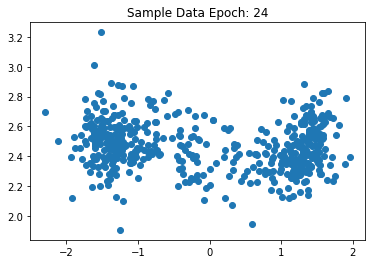

 epoch : 26, tr_recon_loss : 1.0482744206047059, tr_kl_loss : 0.270784676861763
 epoch : 26, te_recon_loss : 1.0606607986075798, te_kl_loss : 0.1865544484647186
 epoch : 27, tr_recon_loss : 1.0408940975522996, tr_kl_loss : 0.26953371965408324
 epoch : 27, te_recon_loss : 1.0248206104235271, te_kl_loss : 0.22657158243400818
 epoch : 28, tr_recon_loss : 1.028769481277466, tr_kl_loss : 0.2704018760061264
 epoch : 28, te_recon_loss : 0.992914533485537, te_kl_loss : 0.23550497833401193
 epoch : 29, tr_recon_loss : 1.0252820996189118, tr_kl_loss : 0.2793438909339905
 epoch : 29, te_recon_loss : 1.0097896038266398, te_kl_loss : 0.22427939355868817
 epoch : 30, tr_recon_loss : 1.0181508350491524, tr_kl_loss : 0.2698872004890442
 epoch : 30, te_recon_loss : 1.0147709389171942, te_kl_loss : 0.23020442552826442


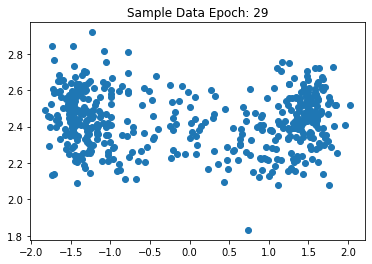

 epoch : 31, tr_recon_loss : 1.0171317288970947, tr_kl_loss : 0.26225102794647215
 epoch : 31, te_recon_loss : 1.0240132863183156, te_kl_loss : 0.20877612307620094
 epoch : 32, tr_recon_loss : 1.0088575313663484, tr_kl_loss : 0.26843351068019866
 epoch : 32, te_recon_loss : 0.9975591316018873, te_kl_loss : 0.22126112804960107
 epoch : 33, tr_recon_loss : 1.0042879760551453, tr_kl_loss : 0.2640514290523529
 epoch : 33, te_recon_loss : 0.9910822273672694, te_kl_loss : 0.2398969828891937
 epoch : 34, tr_recon_loss : 0.991113730866909, tr_kl_loss : 0.26233657623767853
 epoch : 34, te_recon_loss : 1.009709481006998, te_kl_loss : 0.22211650178751066
 epoch : 35, tr_recon_loss : 0.9958706438064575, tr_kl_loss : 0.2600575985956192
 epoch : 35, te_recon_loss : 0.996270986030931, te_kl_loss : 0.2111025147945108


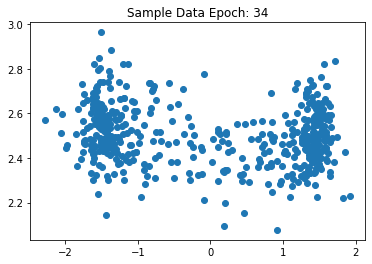

 epoch : 36, tr_recon_loss : 0.979940344619751, tr_kl_loss : 0.2659587064886093
 epoch : 36, te_recon_loss : 0.9663427186858319, te_kl_loss : 0.22714049804031544
 epoch : 37, tr_recon_loss : 0.9842670096683502, tr_kl_loss : 0.25613272916316987
 epoch : 37, te_recon_loss : 0.9615597213854266, te_kl_loss : 0.23354781539086492
 epoch : 38, tr_recon_loss : 0.9760072419691086, tr_kl_loss : 0.2659762101125717
 epoch : 38, te_recon_loss : 0.947505822476676, te_kl_loss : 0.24629738214223282
 epoch : 39, tr_recon_loss : 0.9819559078407287, tr_kl_loss : 0.2574889683532715
 epoch : 39, te_recon_loss : 0.971840486540209, te_kl_loss : 0.2211601364490626
 epoch : 40, tr_recon_loss : 0.9649225302910804, tr_kl_loss : 0.2643695906114578
 epoch : 40, te_recon_loss : 0.9424629823478592, te_kl_loss : 0.24014912064537366


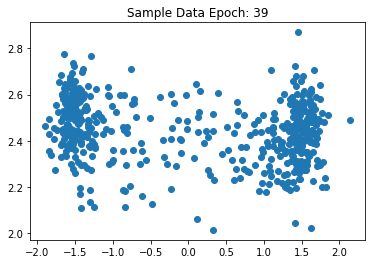

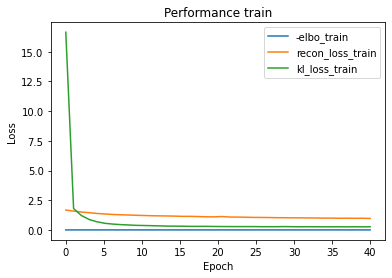

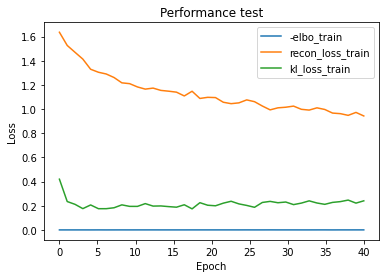

In [18]:
zdim   = 16
epochs = 40
lr = 0.00001
model = VAE(zdim)
model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(),lr=lr)
trainer(model, train_loader, test_loader, optimizer, epochs)

In [19]:
# testing 
model= VAE(zdim)
PATH = path + '/checkpoint/encoder.pt'
model.encoder.load_state_dict(torch.load(PATH))

PATH = path + '/checkpoint/decoder.pt'
model.decoder.load_state_dict(torch.load(PATH))
model.to(device)

VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
      (5): Dropout(p=0.01, inplace=False)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ELU(alpha=1.0, inplace=True)
    )
    (mu): Linear(in_features=128, out_features=16, bias=True)
    (logvar): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)

In [20]:
z = torch.randn(500, zdim).cuda()
gene_sample = model.decoder(z).cpu().detach()

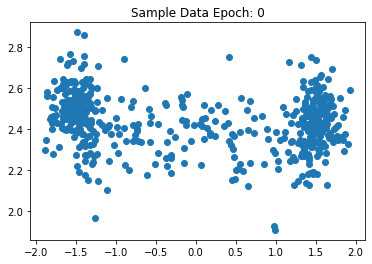

In [21]:
visualize_samples(gene_sample,0)